(planning_acting)=
# Planning and acting with predictive coding networks

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ComputationalPsychiatry/pyhgf/blob/master/docs/source/notebooks/0.4-Planning_and_acting.ipynb)

In [1]:
import sys

from IPython.utils import io

if 'google.colab' in sys.modules:

  with io.capture_output() as captured:
      ! pip install pyhgf watermark

In [2]:
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from jax import random
from jax.random import PRNGKey
import treescope
from pyhgf import load_data
from pyhgf.model import Network
from pyhgf.utils import sample_node_distribution
from pyhgf.utils.sample import sample

np.random.seed(123)
plt.rcParams["figure.constrained_layout.use"] = True

treescope.basic_interactive_setup(autovisualize_arrays=True)

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


This section concerns the application of predictive coding networks to planning and acting. While Bayesian filtering has been applied so far to the perceptual component of the agent, here we are interested in active inference and decision making, where an agent use its current beliefs to estimate future trajectories and select action based on there planned relevance.

## Adding an action layer

By adding a step in the belief propagation function, we can create agents that perform actions and interact with the environment (e.g., influencing the observation it might be presented). When provided, a new function, `action_fn,` can perform actions, decide, or influence the environment after the prediction step and before the observation step.

```{mermaid}
flowchart TB
  A[Predictions] -- Action_fn --> B[Observation]  --> C[Prediction-errors]
```

We illustrate how to implement this by using a two-bandit design, where the value of the contingencies increases or decreases depending on whether the bandit is exploited by the agent. An exploited bandit will decrease its contingency such as: $c = c - (\lambda c)$, whereas a bandit that was not exploited will increase its contingency such as: $c = c + \lambda * (1 - c)$. We, therefore, have to interact with the environment inside the inference loop. Luckily, we can do this by defining the corresponding action function.

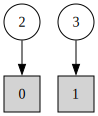

In [3]:
# we start by defining a simple network with two binary branches
network = (
    Network()
    .add_nodes(kind="binary-state", n_nodes=2)
    .add_nodes(value_children=0, tonic_volatility=-2.0)
    .add_nodes(value_children=1, tonic_volatility=-2.0)
)
network.plot_network()

Here, we want to access information from the environment during inference, so we have to wrap this into the `Network.attributes` instance. By convention, all items indexed with positive integers are nodes from the network, and we should not interact with them. Negative integers can be used to index additional information. For example, the time steps are stored in `attributes[-1]["time-steps"]`. Here, we will simply store the contingencies of the two bandits inside the same branch.

In [4]:
network.attributes[-1]["contingencies"] = jnp.array([0.5, 0.5])

We then define the action function. This function should receive and return the `attributes` dictionary, and the `inputs` tuple. By modifying values in this variable, we can change the observed values before they enter the network.

In [5]:
def action_fn(attributes, inputs):

    # unpack the inputs
    values_tuple, observed_tuple, time_step, rng_key = inputs

    # get the current expectation for a reward for both bandits
    mu_0 = attributes[0]["expected_mean"]
    mu_1 = attributes[1]["expected_mean"]

    # sample a new reward from both bandits - the unobserved value will be masked later
    # here simply use the highest expected value to select the bandit
    values_tuple = (
        jnp.int32(random.bernoulli(rng_key, p=attributes[-1]["contingencies"][0])),
        jnp.int32(random.bernoulli(rng_key, p=attributes[-1]["contingencies"][1])),
    )
    observed_tuple = (jnp.int32(mu_0 - mu_1 > 0), jnp.int32(mu_0 - mu_1 <= 0))

    # decrease value of the contingencies for the exploited bandit and increse the value of the non exploited one
    exploited = attributes[-1]["contingencies"] - 0.1 * attributes[-1]["contingencies"]
    non_exploited = attributes[-1]["contingencies"] + 0.1 * (
        1.0 - attributes[-1]["contingencies"]
    )
    attributes[-1]["contingencies"] = jnp.where(
        jnp.array(observed_tuple), exploited, non_exploited
    )

    # create a new input tuple
    inputs = values_tuple, observed_tuple, time_step, rng_key

    return attributes, inputs

We can now provide this function to our main `Network` class, so the model will be aware that this function should be executed inside the belief propagation step.

In [6]:
network.action_fn = action_fn

We are now ready to run the model forward. Here, the input data only inform the number of time steps because we are fully overwriting the input values inside the action function, we could provide any kind of array of same shape and type as well.

In [7]:
# because there is a stochastic component in the reward, we need to pass a pseudorandom number generators
rng_key = random.PRNGKey(0)
network.input_data(input_data=np.ones((100, 2)), rng_keys=random.PRNGKey(0));

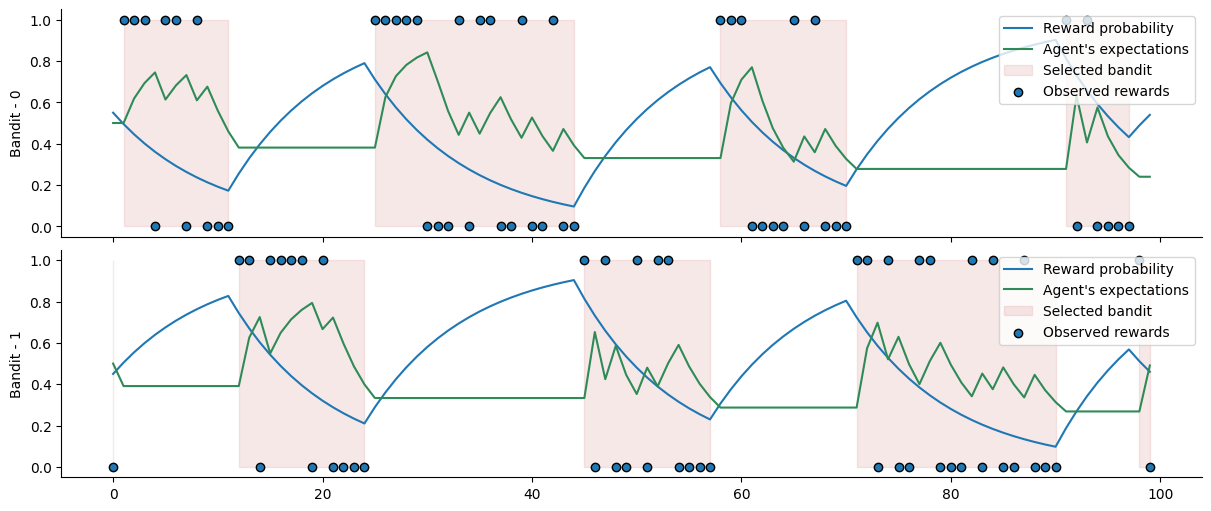

In [8]:
_, axs = plt.subplots(figsize=(12, 5), nrows=2, sharex=True)

for i in range(2):
    axs[i].plot(
        network.node_trajectories[-1]["contingencies"][:, i], label="Reward probability"
    )
    axs[i].plot(
        network.node_trajectories[i]["expected_mean"],
        color="seagreen",
        label="Agent's expectations",
    )
    axs[i].fill_between(
        x=jnp.arange(0, len(network.node_trajectories[-1]["time_step"])),
        y1=0,
        y2=1,
        where=network.node_trajectories[i]["observed"],
        alpha=0.1,
        color="firebrick",
        label="Selected bandit",
    )
    axs[i].scatter(
        x=jnp.arange(0, len(network.node_trajectories[-1]["time_step"]))[
            network.node_trajectories[i]["observed"].astype(bool)
        ],
        y=network.node_trajectories[i]["mean"][
            network.node_trajectories[i]["observed"].astype(bool)
        ],
        edgecolor="k",
        label="Observed rewards",
    )
    axs[i].set(ylabel=f"Bandit - {i}")
    axs[i].legend(loc="upper right")

sns.despine()

## Predicting future belief trajectories

While we have been mostly concerned with an agent's direct observation of the environment, more realistic scenarios involve agents that actively predict possible outcomes to navigate their environment. Predictive neural networks are generative models tracking the latent causes of environmental observations. We can use this generative model to simulate new observations by sampling from the predictive distribution and passing them as new observations to an *imaginary agent*. In this section, we illustrate how to perform such a process which can give insight into expected future outcomes and serve as action selection for active inference.

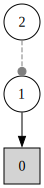

In [9]:
# Define a three-level binary HGF and display the network
three_level_hgf = (
    Network()
    .add_nodes(kind="binary-state")
    .add_nodes(value_children=0, tonic_volatility=-2.0)
    .add_nodes(volatility_children=1, tonic_volatility=-2.0)
)
# Plot the network structure
three_level_hgf.plot_network()

Generative sampling (i.e. sampling an observation from the predictive distribution and passing it for update as actual observation) require a different belief propagation function to be defined beforehand to use the sampling methods. This can be achieved by explicitely passing `sampling_fn=True` when creating the main propagation functions:

In [10]:
# create the belief propagation functions, both for external and generative inputs
three_level_hgf.create_belief_propagation_fn(sampling_fn=True);

From here, we can already sample a set of plausible trajectories using the {py:func}`pyhgf.utils.sample` function. This function returns the attributes dictionary with a belief trajectory for each parameter/simulation. Here, we use the current state of the network and simulate plausible observations forward, and update the model accordingly - we therefore have 50 agents simulating forward in parallel.

```{tip}
You can unroll the nodes/parameters from the dictionary below for interactive visualisation.
```

In [11]:
# sample 50 possible trajectories looking 150 time steps into the future
sample_trajectories = sample(network=three_level_hgf, time_steps=np.ones(150), rng_key=PRNGKey(4), n_predictions=50)
sample_trajectories

{-1: {'time_step': <jax.Array float32(50, 150) ≈1.0 ±0.0 [≥1.0, ≤1.0] nonzero:7_500
    <Arrayviz rendering>
  | Device: CPU 0>},
 0: {'expected_mean': <jax.Array float32(50, 150) ≈0.61 ±0.35 [≥0.0031, ≤1.0] nonzero:7_500
    <Arrayviz rendering>
  | Device: CPU 0>,
  'expected_precision': <jax.Array float32(50, 150) ≈0.12 ±0.087 [≥0.003, ≤0.25] nonzero:7_500
    <Arrayviz rendering>
  | Device: CPU 0>,
  'mean': <jax.Array float32(50, 150) ≈0.62 ±0.48 [≥0.0, ≤1.0] zero:2_837 nonzero:4_663
    <Arrayviz rendering>
  | Device: CPU 0>,
  'observed': <jax.Array int32(50, 150) [≥1, ≤1] nonzero:7_500
    <Arrayviz rendering>
  | Device: CPU 0>,
  'precision': <jax.Array float32(50, 150) ≈0.12 ±0.087 [≥0.003, ≤0.25] nonzero:7_500
    <Arrayviz rendering>
  | Device: CPU 0>,
  'temp': {'value_prediction_error': <jax.Array float32(50, 150) ≈0.037 ±5.2 [≥-1.5e+02, ≤7.9e+01] nonzero:7_500
     <Arrayviz rendering>
   | Device: CPU 0>},
  'value_coupling_parents': (<jax.Array float32(50, 150) ≈1.0 ±0.0 [≥1.0, ≤1.0] nonzero:7_500
     <Arrayviz rendering>
   | Device: CPU 0>,)},
 1: {'autoconnection_strength': <jax.Array float32(50, 150) ≈1.0 ±0.0 [≥1.0, ≤1.0] nonzero:7_500
    <Arrayviz rendering>
  | Device: CPU 0>,
  'expected_mean': <jax.Array float32(50, 150) ≈0.79 ±2.5 [≥-5.8, ≤5.8] zero:50 nonzero:7_450
    <Arrayviz rendering>
  | Device: CPU 0>,
  'expected_precision': <jax.Array float32(50, 150) ≈0.89 ±0.28 [≥0.24, ≤1.3] nonzero:7_500
    <Arrayviz rendering>
  | Device: CPU 0>,
  'mean': <jax.Array float32(50, 150) ≈0.8 ±2.6 [≥-5.8, ≤5.8] nonzero:7_500
    <Arrayviz rendering>
  | Device: CPU 0>,
  'observed': <jax.Array int32(50, 150) [≥1, ≤1] nonzero:7_500
    <Arrayviz rendering>
  | Device: CPU 0>,
  'precision': <jax.Array float32(50, 150) ≈1.0 ±0.36 [≥0.24, ≤1.6] nonzero:7_500
    <Arrayviz rendering>
  | Device: CPU 0>,
  'temp': {'effective_precision': <jax.Array float32(50, 150) ≈0.1 ±0.046 [≥0.018, ≤0.17] nonzero:7_500
     <Arrayviz rendering>
   | Device: CPU 0>,
   'value_prediction_error': <jax.Array float32(50, 150) ≈0.0075 ±0.3 [≥-2.9, ≤2.1] nonzero:7_500
     <Arrayviz rendering>
   | Device: CPU 0>,
   'volatility_prediction_error': <jax.Array float32(50, 150) ≈-0.013 ±0.18 [≥-0.22, ≤2.8] nonzero:7_500
     <Arrayviz rendering>
   | Device: CPU 0>},
  'tonic_drift': <jax.Array float32(50, 150) ≈0.0 ±0.0 [≥0.0, ≤0.0] zero:7_500
    <Arrayviz rendering>
  | Device: CPU 0>,
  'tonic_volatility': <jax.Array float32(50, 150) ≈-2.0 ±0.0 [≥-2.0, ≤-2.0] nonzero:7_500
    <Arrayviz rendering>
  | Device: CPU 0>,
  'value_coupling_children': (<jax.Array float32(50, 150) ≈1.0 ±0.0 [≥1.0, ≤1.0] nonzero:7_500
     <Arrayviz rendering>
   | Device: CPU 0>,),
  'value_coupling_parents': None,
  'volatility_coupling_children': None,
  'volatility_coupling_parents': (<jax.Array float32(50, 150) ≈1.0 ±0.0 [≥1.0, ≤1.0] nonzero:7_500
     <Arrayviz rendering>
   | Device: CPU 0>,)},
 2: {'autoconnection_strength': <jax.Array float32(50, 150) ≈1.0 ±0.0 [≥1.0, ≤1.0] nonzero:7_500
    <Arrayviz rendering>
  | Device: CPU 0>,
  'expected_mean': <jax.Array float32(50, 150) ≈-0.24 ±0.21 [≥-0.72, ≤0.27] zero:50 nonzero:7_450
    <Arrayviz rendering>
  | Device: CPU 0>,
  'expected_precision': <jax.Array float32(50, 150) ≈0.26 ±0.13 [≥0.059, ≤0.88] nonzero:7_500
    <Arrayviz rendering>
  | Device: CPU 0>,
  'mean': <jax.Array float32(50, 150) ≈-0.24 ±0.21 [≥-0.72, ≤0.27] nonzero:7_500
    <Arrayviz rendering>
  | Device: CPU 0>,
  'observed': <jax.Array int32(50, 150) [≥1, ≤1] nonzero:7_500
    <Arrayviz rendering>
  | Device: CPU 0>,
  'precision': <jax.Array float32(50, 150) ≈0.27 ±0.14 [≥0.06, ≤0.89] nonzero:7_500
    <Arrayviz rendering>
  | Device: CPU 0>,
  'temp': {'effective_precision': <jax.Array float32(50, 150) ≈0.036 ±0.018 [≥0.008, ≤0.12] nonzero:7_500
     <Arrayviz rendering>
   | Device: CPU 0>,
   'value_prediction_error': <jax.Array float32(50, 150) ≈0.0 ±0.0 [≥0.0, ≤0.0] zero:7_500
     <Arrayviz rendering>
   | Devic

Alternatively, this simulation can take place after observing some data, in which case the last stat of the network is used and the simulation of plausible trajectories is just run forwards.

In [12]:
u, y = load_data("binary")
three_level_hgf.input_data(input_data=u);

In [13]:
# sample 50 possible trajectories looking 100 time steps into the future
three_level_hgf.sample(time_steps=np.ones(100), rng_key=PRNGKey(4), n_predictions=50);

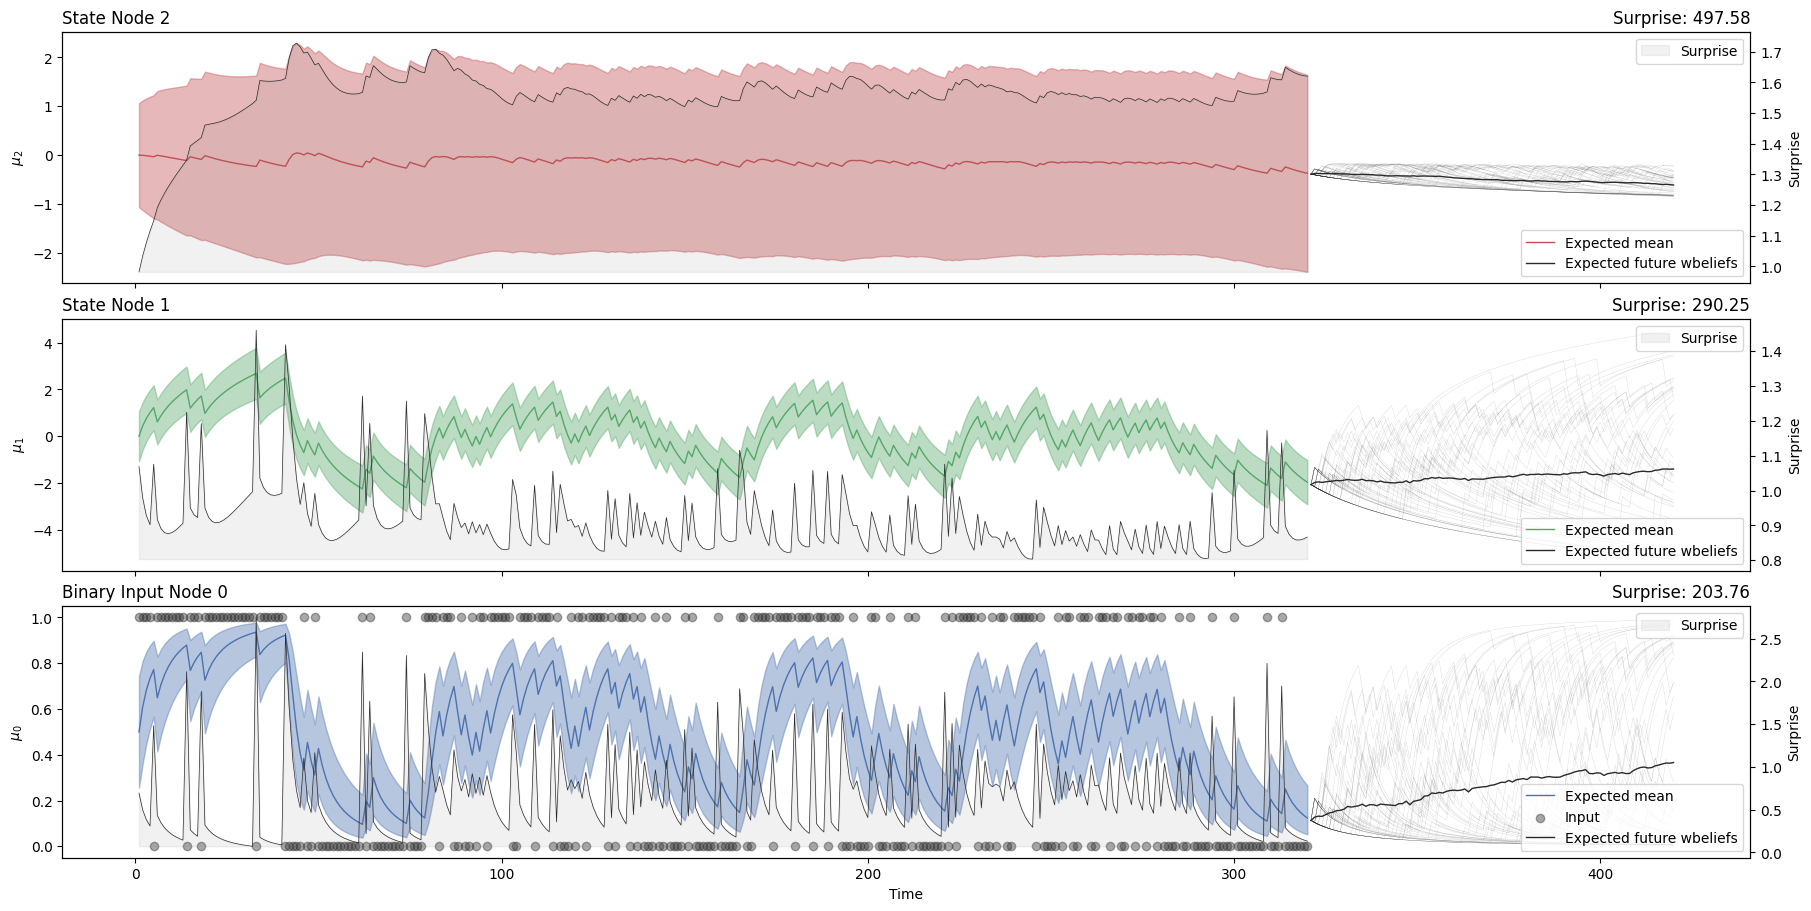

In [14]:
# plot the belief trajectories (observed data)
axs = three_level_hgf.plot_trajectories()

# add the plausible simulation at the end of the time series to indicate future expectations
three_level_hgf.plot_samples(axs=axs);

## Approaching active inference
```{warning}
Work in progress
```

# System configuration

In [15]:
%load_ext watermark
%watermark -n -u -v -iv -w -p pyhgf,jax,jaxlib

Last updated: Mon Apr 28 2025

Python implementation: CPython
Python version       : 3.12.3
IPython version      : 9.0.2

pyhgf : 0.2.4.post4.dev0+86609d57
jax   : 0.4.31
jaxlib: 0.4.31

matplotlib: 3.10.1
sys       : 3.12.3 | packaged by conda-forge | (main, Apr 15 2024, 18:38:13) [GCC 12.3.0]
numpy     : 1.26.0
IPython   : 9.0.2
jax       : 0.4.31
seaborn   : 0.13.2
pyhgf     : 0.2.4.post4.dev0+86609d57
treescope : 0.1.9

Watermark: 2.5.0

